In [1]:
import gc
import numpy as np
import pandas as pd
import xarray as xr
import metpy.constants as mpconsts

from glob import glob
from os.path import isfile
from functools import reduce
from datetime import datetime, timedelta

from sklearn.metrics import r2_score
from scipy.stats import gaussian_kde, skew

import matplotlib.pyplot as plt

## Define paths and acquire list of available data

In [2]:
obdir = '/uufs/chpc.utah.edu/common/home/steenburgh-group10/mewessler/observations/'
profdir = '/uufs/chpc.utah.edu/common/home/steenburgh-group10/mewessler/era5/profiles/'

## Build into a loop over all stations

In [3]:
flist = glob(obdir + 'clean/*.pd')

# This can be a manual site list if desired
site_list = [f.split('/')[-1].split('_')[0] for f in flist]
site_list

['CLN', 'ALTA', 'AGD', 'BCC', 'SLB', 'PVC', 'BSNFEX', 'BSNFJE', 'BSNFDC']

In [4]:
# for site in site_list:
site = 'ALTA'

### Obtain the metadata

In [5]:
meta_file = glob(obdir + '*Metadata*.xlsx')[0]
metadata = pd.read_excel(meta_file).set_index('code').loc[site]

# Determine the lat, lon of the site from the metadata
site_lat, site_lon = metadata['lat'], metadata['lon']
site_elev = metadata['elevation_m']

metadata

name                                                   Alta CoOp
owner                                   National Weather Service
city                                                        Alta
state                                                         UT
lat                                                      40.5906
lon                                                     -111.637
elevation_m                                                 2655
start                                                        NaN
end                                                          NaN
interval                                                   12/24
n_events                                                     NaN
auto_manual                                               Manual
snow_type                                                    NaN
swe_type                                                     NaN
notes          24h Precip observed at 1600 in earlier record,...
Name: ALTA, dtype: object

### Import the ERA5 Profile

In [6]:
# Import the era5_orog file to check the lat/lon grid
era_dir = '/uufs/chpc.utah.edu/common/home/steenburgh-group10/mewessler/era5/'
era5_orog_file = era_dir + 'era5_orog.nc'
era5_orog = xr.open_dataset(era5_orog_file)['z'].isel(time=0)
era5_orog = era5_orog.rename({'latitude':'lat', 'longitude':'lon'})
era5_lat, era5_lon = era5_orog['lat'], era5_orog['lon']

# Find the index of the correct lat lon
idx1d = (np.abs(era5_lon - site_lon) + np.abs(era5_lat - site_lat))
idx = np.unravel_index(np.argmin(idx1d, axis=None), idx1d.shape)

# Subset and convert gpm to m
era5_g = 9.80665
era5_orog = era5_orog.isel(lat=idx[1], lon=idx[0])/era5_g

era5_lat, era5_lon = era5_orog['lat'].values, era5_orog['lon'].values
era5_elev = era5_orog.values

print('ERA5 Profile:\n%.2f %.2f %.2f\n'%(era5_lat, era5_lon, era5_elev))

era5_prof_file = 'era5prof_{}N_{}W.nc'.format(
    era5_orog['lat'].values, abs(era5_orog['lon'].values))

if isfile(era_dir + 'profiles/' + era5_prof_file):
    era5_prof = xr.open_dataset(era_dir + 'profiles/' + era5_prof_file).load()
    era5_prof = era5_prof.dropna(dim='time')
    print(era5_prof)
    
else:
    print('ERA5 Profile Missing:\n%s'%era5_prof_file)

ERA5 Profile:
40.50 -111.75 1967.42

<xarray.Dataset>
Dimensions:  (level: 23, time: 328704)
Coordinates:
  * time     (time) datetime64[ns] 1980-01-01 ... 2019-06-30T23:00:00
  * level    (level) float64 200.0 225.0 250.0 300.0 ... 925.0 950.0 975.0 1e+03
Data variables:
    Q        (time, level) float32 8.430327e-06 2.2606831e-05 ... 0.0056080474
    T        (time, level) float32 213.56236 213.23013 ... 302.55365 303.83582
    U        (time, level) float32 32.258484 38.37195 ... -0.18589783
    V        (time, level) float32 2.0954742 2.2194977 ... 4.7066345 4.6651
    VO       (time, level) float32 6.204704e-06 ... -0.000121165765
    W        (time, level) float32 0.017477036 0.077495575 ... -0.11104393
    Z        (time, level) float32 115597.81 108389.75 ... 3440.6726 1319.3672
    R        (time, level) float32 23.817059 75.24865 ... 28.302814 28.428883
    U100M    (time) float32 -0.80430603 -0.3778534 ... 0.10606384 -0.1478424
    V100M    (time) float32 3.1638489 2.974456

### Import the surface observations

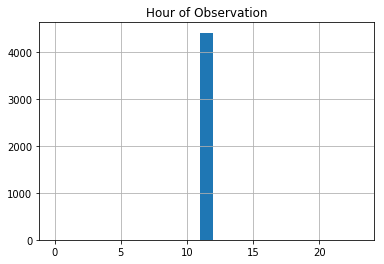

In [7]:
try:
    obs = pd.read_pickle(glob(obdir + 'clean/%s*.pd'%site)[0]).reset_index().rename(
        columns={'index':'time'}).set_index('time')
except:
    obs = pd.read_pickle(glob(obdir + 'clean/%s*.pd'%site)[0]).reset_index().rename(
        columns={'datetime_utc':'time'}).set_index('time')

obs = obs[obs.index > datetime(1980, 8, 1)]
obs = obs.dropna()

plt.figure(facecolor='w')
plt.hist([t.hour for t in obs.index], bins=np.arange(0, 24, 1))
plt.grid()
plt.title('Hour of Observation')
plt.show()

obs[:10]

intervals = [int(k.replace('slr', '')) for k in obs if 'slr' in k]

### Prune observations based on minimum qpf, snow, and max T 

In [8]:
try:
    obs = obs[((obs['swe12_mm'] > 1.4) & (obs['snow12_mm'] >= 25.5))]
except:
    print('24h Data Used to Constrain SWE/SNOW')
    obs = obs[((obs['swe24_mm'] > 2.8) & (obs['snow24_mm'] >= 51.0))]
else:
    print('12h Data Used to Constrain SWE/SNOW')

print(obs.shape)

try:
    obs = obs.drop_duplicates()
except:
    pass
else:
    print(obs.shape)

obs = obs.iloc[np.where(np.array([len(pp) for pp in obs['precip_periods']]) > 0)[0]]
print(obs.shape)

24h Data Used to Constrain SWE/SNOW
(1882, 8)
(1882, 8)
(1882, 8)


### Investigate the data with a few plots

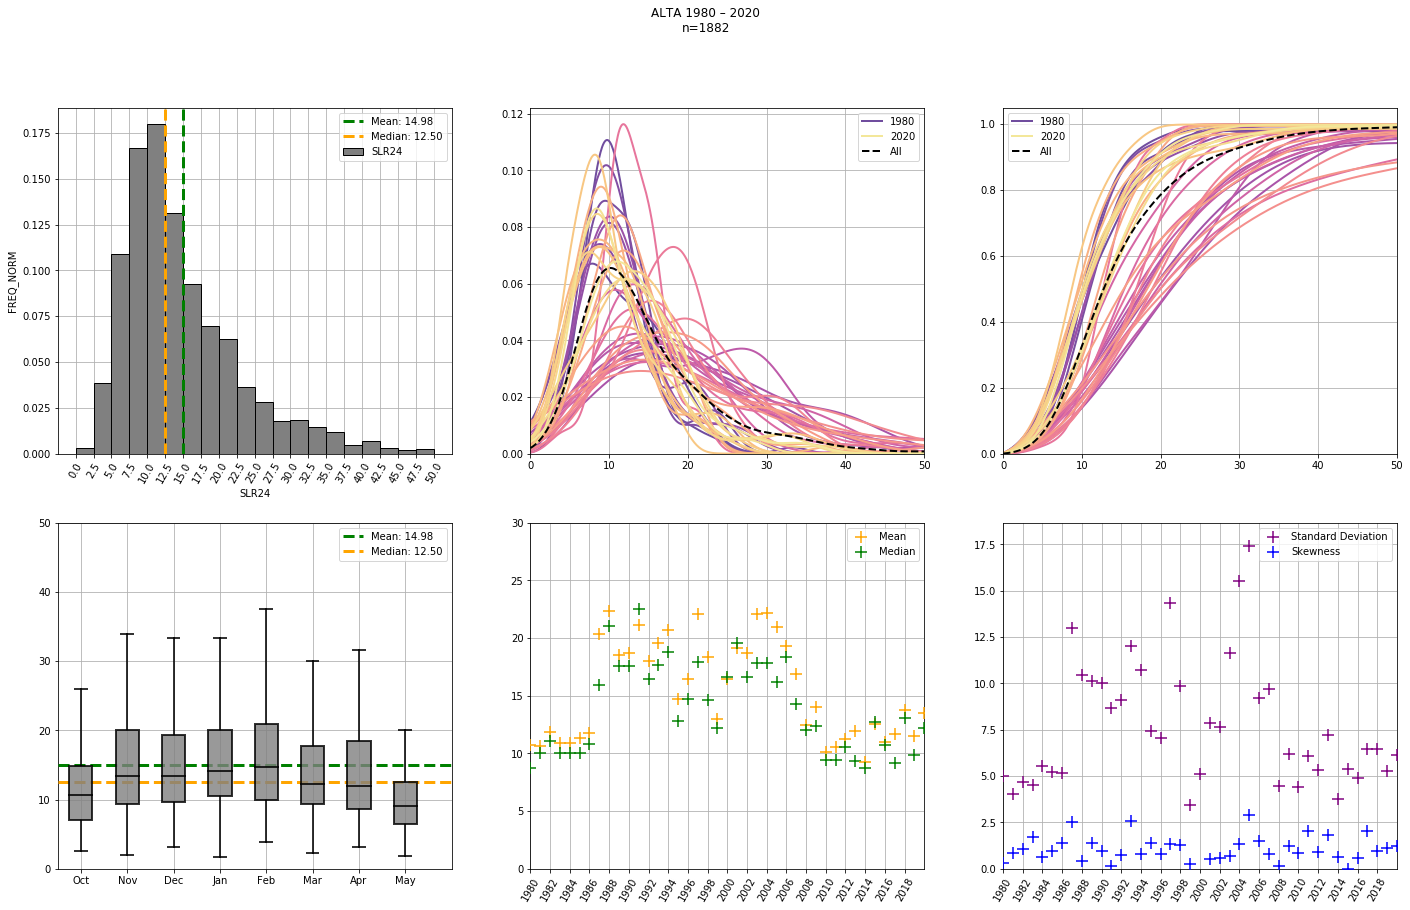

In [9]:
ycolors = ("#704D9E","#704D9E","#7A4EA0","#824EA3","#8B4FA4","#9350A6","#9B51A7","#A253A8","#AA54A9",
           "#B156A9","#B758A9","#BE5AA9","#C45DA8","#CA60A7","#CF63A6","#D566A4","#DA6AA3","#DE6DA1",
           "#E3719E","#E7759C","#EB7A99","#EE7F96","#F18493","#F28A90","#F48F8D","#F5958B","#F79A88",
           "#F7A086", "#F8A684","#F9AB83","#F9B182","#F9B681","#F9BC81","#F9C182","#F8C783","#F8CC85",
           "#F7D288","#F6D78B","#F5DC8F","#F4E294","#F3E79A")

binwidth = 2.5

for k in [k for k in obs if 'slr' in k]:

    fig, axs = plt.subplots(2, 3, figsize=(24, 14), facecolor='w')
    axs = axs.flatten()
    ax1, ax2, ax3, ax4, ax5, ax6 = axs
    
    histargs = {'width':1, 'color':'0.5', 'edgecolor':'k', 'zorder':10}
    vlineargs = {'linewidth':3, 'linestyle':'--', 'zorder':11}
    xyargs = {'s':150, 'marker':'+', 'linewidth':1.5, 'zorder':10}
    
    v1, b1 = np.histogram(obs[k].values, bins=np.arange(0, 50+1, binwidth))    
    ax1.bar(np.arange(.5, len(v1), 1), v1/sum(v1), label=k.upper(), **histargs)
    vmean = obs[k].mean()
    ax1.axvline(vmean/binwidth, c='green', label='Mean: %.2f'%vmean, **vlineargs)
    vmed = obs[k].median()
    ax1.axvline(vmed/binwidth, c='orange', label='Median: %.2f'%vmed, **vlineargs)
    
    ax1.set_xticks(np.arange(len(b1)))
    ax1.set_xticklabels(b1, rotation=60)
    ax1.set_xlabel(k.upper())
    ax1.set_ylabel('FREQ_NORM')
    
    years = np.unique([t.year for t in obs.index])
    nyears = len(years)
    ygrays = np.linspace(.8, .4, nyears).astype(str)
    
    colid = np.linspace(0, len(ycolors)-1, nyears, dtype=int)
    
    for i, year in enumerate(np.unique([t.year for t in obs.index])):
        
        label = year if i==0 or i==nyears-1 else None
        yobs = obs[k].iloc[[i for i, t in enumerate(obs.index) if t.year == year]]

        try:
            n, x = np.histogram(yobs, bins=np.arange(0, 50+1, 0.1))
            ax2.plot(x, gaussian_kde(yobs)(x), color=ycolors[colid[i]], linewidth=2, label=label)

            n, x = np.histogram(yobs, bins=np.arange(0, 50+1, 0.1))
            ax3.plot(x, np.cumsum(gaussian_kde(yobs)(x))/10, color=ycolors[colid[i]], linewidth=2, label=label)
        except:
            pass
        
        ax5.scatter(year, yobs.mean(), c='orange', **xyargs)
        ax5.scatter(year, yobs.median(), c='green', **xyargs)        
        ax6.scatter(year, np.std(yobs), c='purple', **xyargs)
        ax6.scatter(year, skew(yobs), c='blue', **xyargs)
        
    ax5.scatter(year, -1, c='orange', label='Mean', **xyargs)
    ax5.scatter(year, -1, c='green', label='Median', **xyargs)        
    ax6.scatter(year, -1, c='purple', label='Standard Deviation', **xyargs)
    ax6.scatter(year, -1, c='blue', label='Skewness', **xyargs)

    n, x = np.histogram(yobs, bins=np.arange(0, 50+1, 0.1))
    ax2.plot(x, gaussian_kde(obs[k])(x), 'k--', linewidth=2, label='All')
    n, x = np.histogram(yobs, bins=np.arange(0, 50+1, 0.1))
    ax3.plot(x, np.cumsum(gaussian_kde(obs[k])(x))/10, 'k--', linewidth=2, label='All')
    
    mobs = []
    for i, month in enumerate([10, 11, 12, 1, 2, 3, 4, 5]):
        mobs.append(obs[k].iloc[[i for i, t in enumerate(obs.index) if t.month == month]])
        
    bp = ax4.boxplot(mobs, showfliers=False, patch_artist=True, zorder=15)
    [[box.set(linewidth=2, color='k', alpha=0.8) for box in bp[k]] 
         for k in ['boxes', 'whiskers', 'medians', 'means', 'caps']]
    [patch.set_facecolor('0.5') for patch in bp['boxes']]
    
    ax4.axhline(vmean, c='green', label='Mean: %.2f'%vmean, **vlineargs)
    ax4.axhline(vmed, c='orange', label='Median: %.2f'%vmed, **vlineargs)
    
    ax4.set_xlim(right=9)
    ax4.set_ylim([0, 50])
    ax4.set_xticklabels(['Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May'])
    
    ax5.set_ylim(top=30)
    for ax in [ax5, ax6]:
        ax.set_xlim([years[0], years[-1]])
        ax.set_xticks(np.arange(years[0], years[-1], 1)[::2])
        ax.set_xticklabels(np.arange(years[0], years[-1], 1)[::2], rotation=60)
    
    for ax in [ax2, ax3]:
        ax.set_xlim(right=50)
        ax.set_xlim(left=0)
    
    for ax in axs:
        ax.set_ylim(bottom=0)
        ax.legend()
        ax.grid()
    
    plt.suptitle('%s %d – %d\nn=%d'%(site, years[0], years[-1], obs.index.size))
    # plt.tight_layout()
    plt.show()
    plt.close()

### Trim the sub-surface levels out here
Probably best to nan them out rather than get rid of the levels themselves for easier indexing later...

In [10]:
# Noting that the GFS has less vertical levels than the ERA5, 
# trim here if we are going to use index vs matched levels
gfs_levels = [200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 
              700, 750, 800, 850, 900, 925, 950, 975, 1000]

era5_prof = era5_prof.sel(level=gfs_levels)

era5_prof

<xarray.Dataset>
Dimensions:  (level: 19, time: 328704)
Coordinates:
  * time     (time) datetime64[ns] 1980-01-01 ... 2019-06-30T23:00:00
  * level    (level) float64 200.0 250.0 300.0 350.0 ... 925.0 950.0 975.0 1e+03
Data variables:
    Q        (time, level) float32 8.430327e-06 3.2368283e-05 ... 0.0056080474
    T        (time, level) float32 213.56236 215.20003 ... 302.55365 303.83582
    U        (time, level) float32 32.258484 41.255234 ... -0.18589783
    V        (time, level) float32 2.0954742 0.9229889 ... 4.7066345 4.6651
    VO       (time, level) float32 6.204704e-06 ... -0.000121165765
    W        (time, level) float32 0.017477036 0.23659134 ... -0.11104393
    Z        (time, level) float32 115597.81 101921.0 ... 3440.6726 1319.3672
    R        (time, level) float32 23.817059 91.1597 ... 28.302814 28.428883
    U100M    (time) float32 -0.80430603 -0.3778534 ... 0.10606384 -0.1478424
    V100M    (time) float32 3.1638489 2.9744568 2.462204 ... 7.476593 7.7515106
    U

In [12]:
trim_elev = metadata['elevation_m']
use_min = False

# If we want to use the GFS elevation we can import it here
print('ERA5 Elevation: %dm\nMeasured Elevation: %dm'%(
    era5_elev, metadata['elevation_m']))

zmean = era5_prof['Z'].mean(dim='time')/era5_g
zmax = era5_prof['Z'].max(dim='time')/era5_g
zmin = era5_prof['Z'].min(dim='time')/era5_g

for level in era5_prof.level.values:
 
    zcompare = zmean.sel(level=level)
    zcompare1 = zmin.sel(level=level) if use_min else zcompare
    
    if ((zcompare >= trim_elev)&(zcompare1 >= trim_elev)):
        lowest_level = level
    
    else:
        print('\nLowest Level Kept: %d mb\n\tMean Z: %.2f\n\tMax Z: %.2f\n\tMin Z: %.2f'%(
            lowest_level, zmean.sel(level=lowest_level),
            zmax.sel(level=lowest_level), zmin.sel(level=lowest_level)))
        
        print('\nTrim Level: %d mb\n\tMean Z: %.2f\n\tMax Z: %.2f\n\tMin Z: %.2f'%(
            level, zmean.sel(level=level),
            zmax.sel(level=level), zmin.sel(level=level)))
        
        break

# May want to consdier leaving the levels in and using a nan-fill if this
# proves difficult to merge into a larger dataframe later
era5_prof = era5_prof.sel(level=slice(era5_prof.level.min(), lowest_level))
era5_prof

ERA5 Elevation: 1967m
Measured Elevation: 2655m

Lowest Level Kept: 700 mb
	Mean Z: 3090.58
	Max Z: 3271.26
	Min Z: 2739.35

Trim Level: 750 mb
	Mean Z: 2530.88
	Max Z: 2689.19
	Min Z: 2194.65


<xarray.Dataset>
Dimensions:  (level: 11, time: 328704)
Coordinates:
  * time     (time) datetime64[ns] 1980-01-01 ... 2019-06-30T23:00:00
  * level    (level) float64 200.0 250.0 300.0 350.0 ... 550.0 600.0 650.0 700.0
Data variables:
    Q        (time, level) float32 8.430327e-06 3.2368283e-05 ... 0.0051149745
    T        (time, level) float32 213.56236 215.20003 ... 277.8679 282.50775
    U        (time, level) float32 32.258484 41.255234 ... 4.8536835 3.4658356
    V        (time, level) float32 2.0954742 0.9229889 ... 3.5596008 9.791275
    VO       (time, level) float32 6.204704e-06 -4.6708854e-05 ... 6.541773e-05
    W        (time, level) float32 0.017477036 0.23659134 ... 0.4465189
    Z        (time, level) float32 115597.81 101921.0 ... 37041.566 31065.64
    R        (time, level) float32 23.817059 91.1597 ... 53.566437 46.793076
    U100M    (time) float32 -0.80430603 -0.3778534 ... 0.10606384 -0.1478424
    V100M    (time) float32 3.1638489 2.9744568 2.462204 ... 7.4765

In [ ]:
# 10 levels allows stations as high as 650 mb. 
# If higher is needed, add gfs_levels above 200 mb
num_levels = 10

era5_prof = era5_prof.sel(level=sorted(era5_prof.level[num_levels*-1:])[::-1])
era5_prof['level'] = np.arange(num_levels) + 1
era5_prof

### Take care of the derived variables
Wind Speed, Wind Direction<br>


In [ ]:
for level_set in ['', '10M', '100M']:
    
    u = era5_prof['U%s'%level_set] 
    v = era5_prof['V%s'%level_set]
    
    wspd = np.sqrt((u**2) + (v**2))
    wdir = 90 - np.degrees(np.arctan2(-v, -u))
    wdir = xr.where(wdir <= 0, wdir+360, wdir)
    wdir = xr.where(((u == 0) & (v == 0)), 0, wdir)
    
    era5_prof['SPD%s'%level_set] = wspd.astype(np.float32)
    era5_prof['DIR%s'%level_set] = wdir.astype(np.float32)

In [ ]:
era5_prof

### Resample to observation interval
From 1h or 3h ERA5 to 6, 12, 24h observations<br>
I think we need to manually resample here...<br>
to account for irregular observation intervals at some stations

In [ ]:
resample_these = {
    'max':['Q', 'T', 'U', 'V', 'VO', 'W', 'Z', 'R', 'T2M', 'D2M', 'BLH', 'CAPE', 'MSL',
           'SP', 'SPD', 'U10M', 'V10M', 'U100M', 'V100M', 'SPD10M', 'DIR10M', 'SPD100M', 'DIR100M'],
    
    'min':['Q', 'T', 'VO', 'Z', 'R', 'T2M', 'D2M', 'MSL', 'SP'],
    
    'mean':['Q', 'T', 'U', 'V', 'VO', 'W', 'Z', 'R', 'T2M', 'D2M', 'BLH', 'CAPE', 'MSL', 
           'SP', 'SPD', 'U10M', 'V10M', 'U100M', 'V100M', 'SPD10M', 'DIR10M', 'SPD100M', 'DIR100M']}

In [ ]:
for interval in intervals:
    
    left_inclusive = True
    right_inclusive = True

    era5_resampled = []

    for i, t in enumerate(obs.index):

        # Determine start, end
        ti = t - timedelta(hours=interval)    
        ti = ti if left_inclusive else ti + timedelta(hours=1)
        tf = t if right_inclusive else t - timedelta(hours=1)    
        
        try:
            era5_slice = era5_prof.sel(time=obs.loc[t]['precip_periods'])
        except:
            era5_slice = era5_prof.sel(time=slice(ti, tf))

        if era5_slice.time.size > 0:

            print('\rresampling %dh %d/%d (slice size %d)'%(interval, i+1, len(obs.index), era5_slice.time.size), end='')

            slice_max = era5_slice[resample_these['max']].max(dim='time')
            slice_min = era5_slice[resample_these['min']].min(dim='time')
            slice_mean = era5_slice[resample_these['mean']].mean(dim='time')

            slice_all = []
            for oper in ['max', 'min', 'mean']:
                slice_oper = vars()['slice_%s'%oper]

                for k in slice_oper.keys():
                    slice_oper = slice_oper.rename({k:'%s_%s'%(k, oper)})

                    # Ensure that we label the observation time appropriately
                    slice_oper['time'] = t

                slice_all.append(slice_oper)

            era5_resampled.append(xr.merge(slice_all))

    era5_resampled = xr.concat(era5_resampled, dim='time').dropna(dim='time')
    print()

    ### Transform 2D vars (level, time) to 1D vars (time) for model input
    isokeys = [k for k in era5_resampled if len(era5_resampled[k].shape) > 1]
    sfckeys = [k for k in era5_resampled if len(era5_resampled[k].shape) == 1]

    era5_df = []

    for l in era5_resampled.level.values:

        level_data = era5_resampled[isokeys].sel(level=l).drop('level')#.to_dataframe()
        level_data = level_data.rename({k:'%s%s_%s'%(k.split('_')[0], '_%02dagl'%l, k.split('_')[-1]) for k in level_data.keys()})

        era5_df.append(level_data)

    era5_df = xr.merge(era5_df)
    era5_df = xr.merge([era5_df, era5_resampled[sfckeys]])

    era5_df = era5_df.to_dataframe()
    era5_df = era5_df.drop_duplicates().dropna().sort_index()

    droplist = [k for k in obs.keys() if (('slr%d'%interval not in k)&('swe%d'%interval not in k))]

    df_merged = obs.drop(columns=droplist).rename(columns={k:k.replace('%d'%interval, '') 
                    for k in obs.drop(columns=droplist).keys()})
    
    df_merged = df_merged.merge(era5_df, on='time', copy=False)
    
    df_merged = df_merged.loc[np.in1d(era5_df.index, obs.index)]

    print(interval, df_merged.shape)
    df_merged.iloc[:10, :12]
    
    # df_save[interval] = df_merged.copy()
    start, end = df_merged.index[0].year, df_merged.index[-1].year
    df_savestr = obdir + 'combined/' + '%s_%04d_%04d.%02dh.pd'%(site, start, end, interval)
    df_merged.to_pickle(df_savestr)
    print('Saved:\n%s'%df_savestr)
    #del df_merged
    #gc.collect()